<a href="https://colab.research.google.com/github/owenburton/DS-Unit-2-Applied-Modeling/blob/master/module3/assignment_applied_modeling_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---


# Applied Modeling, Module 3

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to iterate on your project: data cleaning, exploration, feature engineering, modeling.
- [ ] Make at least 1 partial dependence plot to explain your model.
- [ ] Share at least 1 visualization on Slack.

(If you have not yet completed an initial model yet for your portfolio project, then do today's assignment using your Tanzania Waterpumps model.)

## Stretch Goals
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox. Get readable category names on your plot, instead of integer category codes.

## Links
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pdpbox

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')

from sklearn.model_selection import train_test_split
import numpy as np

target = 'status_group'
train, val = train_test_split(train, test_size=len(test), stratify=train[target],
                              random_state=42)
def wrangle(X):
    X = X.copy()

    X['latitude'] = X['latitude'].replace(-2e-08, 0)

    cols_with_zeroes = ['longitude', 'latitude', 'construction_year', 'gps_height', 
                      'population']
    for col in cols_with_zeroes:
        X[col] = X[col].replace(0, np.nan)
        X[col+'_MISSING'] = X[col].isnull()

    dropped = ['quantity_group', 'payment_type', 'recorded_by', 'id']
    X = X.drop(columns=dropped)
  
    dr = 'date_recorded'
    X[dr] = pd.to_datetime(X[dr], infer_datetime_format=True)
  
    X['year_recorded'] = X[dr].dt.year
    X['month_recorded'] = X[dr].dt.month 
    X['day_recorded'] = X[dr].dt.day
    X = X.drop(columns=dr)

    X['years'] = X['year_recorded'] - X['construction_year']
    X['years_missing'] = X['years'].isnull()

    return X

train = wrangle(train)
val = wrangle(val)

X_train = train.drop(columns=target)
y_train = train[target]
X_val = val.drop(columns=target)
y_val = val[target]

import category_encoders as ce
from sklearn.impute import SimpleImputer
from lightgbm import LGBMClassifier
from sklearn.pipeline import make_pipeline

In [0]:
# Use Ordinal Encoder out of pipeline.
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)

pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    LGBMClassifier(random_state=42)
)

pipe.fit(X_train_encoded, y_train);

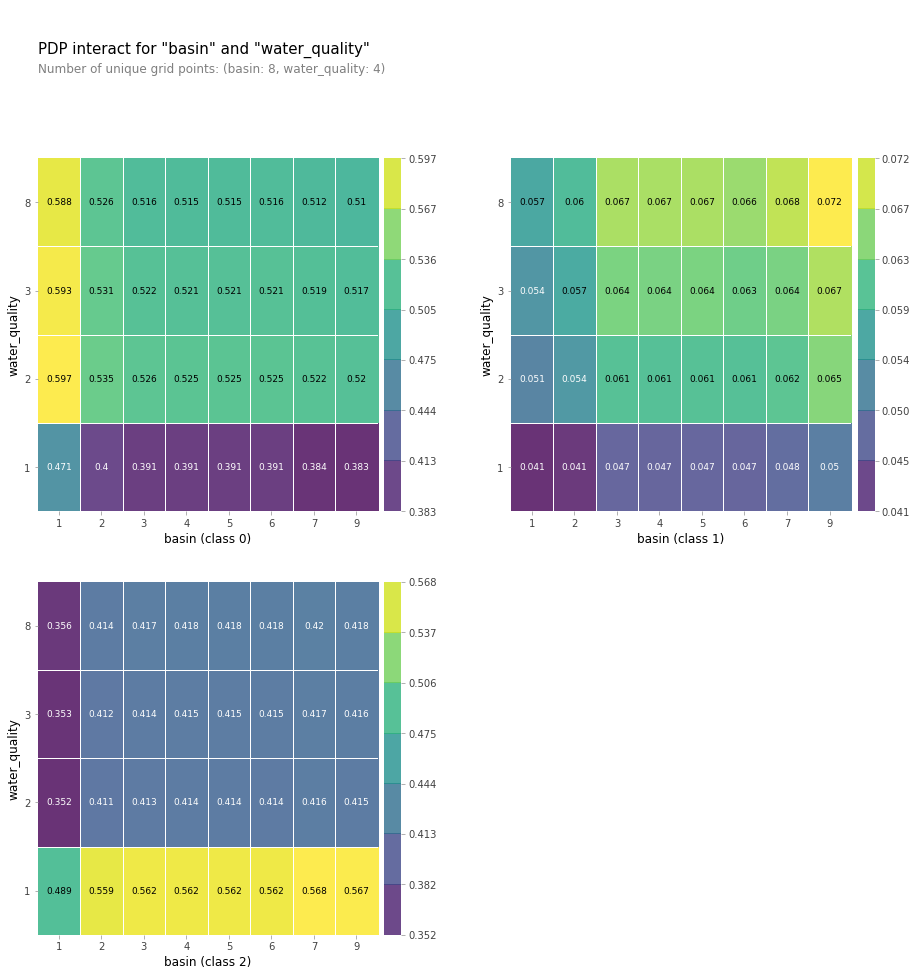

In [37]:
# Use Pdpbox
%matplotlib inline
import matplotlib.pyplot as plt
from pdpbox import pdp
from pdpbox.pdp import pdp_interact, pdp_interact_plot

feature = 'basin'
features = X_train.columns

for item in encoder.mapping:
    if item['col'] == feature:
        feature_mapping = item['mapping']
        
feature_mapping = feature_mapping[feature_mapping.index.dropna()]
category_names = feature_mapping.index.tolist()
category_codes = feature_mapping.values.tolist()

features = ['basin', 'water_quality']

interaction = pdp_interact(
    model=model, 
    dataset=X_train_encoded, 
    model_features=X_train_encoded.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

In [39]:
pdp = interaction.pdp.pivot_table(
    values='preds', 
    columns=features[0], # First feature on x axis
    index=features[1]    # Next feature on y axis
)
# [::-1]  # Reverse the index order so y axis is ascending

pdp = pdp.rename(columns=dict(zip(category_codes, category_names)))
plt.figure(figsize=(10,8))
sns.heatmap(pdp, annot=True, fmt='.2f', cmap='viridis')
plt.title('Partial dependence of water pump condition on basin');

AttributeError: ignored